In [1]:
import tensorflow as tf
import numpy as np
import os,math,re,sys
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE" #CPU Only

#os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'#GPU Running

import matplotlib.pylab as plt
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
AUTO = tf.data.experimental.AUTOTUNE
print("Tensorflow version " + tf.__version__)

Tensorflow version 2.8.0


In [2]:
strategy = tf.distribute.MirroredStrategy(devices=None) #Use all available GPUs or CPU
print("REPLICAS:", strategy.num_replicas_in_sync)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
REPLICAS: 1


2022-04-28 10:23:37.797881: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
IMG_SIZE = [512,512]
BATCH_SIZE = 16
EPOCHS = 40

LR_START = 0.00001
LR_MAX = 0.0001 * strategy.num_replicas_in_sync
LR_MIN = 0.00001
LR_RAMPUP_EPOCHS = 0
LR_SUSTAIN_EPOCHS = 0
LR_EXP_DECAY = .93

def scheduler_epoch(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        learning_rate = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        learning_rate = LR_MAX
    else:
        learning_rate = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return learning_rate
                
lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler_epoch, verbose=True)

In [4]:
DataSet_Path = '/Users/zhuzhirui/.keras/datasets/104_Flowers'
Train_Size_Choice = {
    192: DataSet_Path + '/jpeg-192x192_train.tfrecord',
    224: DataSet_Path + '/jpeg-224x224_train.tfrecord',
    311: DataSet_Path + '/jpeg-311x311_train.tfrecord',
    512: DataSet_Path + '/jpeg-512x512_train.tfrecord'
}

Val_Size_Choice = {
    192: DataSet_Path + '/jpeg-192x192_val.tfrecord',
    224: DataSet_Path + '/jpeg-224x224_val.tfrecord',
    311: DataSet_Path + '/jpeg-311x311_val.tfrecord',
    512: DataSet_Path + '/jpeg-512x512_val.tfrecord'
}

TrainSet_Path = Train_Size_Choice[IMG_SIZE[0]]
ValSet_Path = Val_Size_Choice[IMG_SIZE[0]]

CLASS = ['toad lily', 'love in the mist', 'monkshood', 'azalea', 'fritillary', 
         'silverbush', 'canterbury bells', 'stemless gentian', 'pink primrose', 'buttercup', 
         'poinsettia', 'desert-rose', 'bird of paradise', 'columbine', 'frangipani', 
         'sweet pea', 'siam tulip', 'great masterwort', 'hard-leaved pocket orchid', 'marigold', 
         'foxglove', 'wild pansy', 'windflower', 'daisy', 'tiger lily', 
         'purple coneflower', 'orange dahlia', 'globe-flower', 'lilac hibiscus', 'fire lily', 
         'balloon flower', 'iris', 'bishop of llandaff', 'yellow iris', 'garden phlox', 
         'alpine sea holly', 'geranium', 'pink quill', 'tree poppy', 'spear thistle', 
         'bromelia', 'common dandelion', 'sword lily', 'peruvian lily', 'carnation', 
         'cosmos', 'spring crocus', 'lotus', 'bolero deep blue', 'anthurium', 
         'rose', 'water lily', 'primula', 'blackberry lily', 'gaura', 
         'trumpet creeper', 'globe thistle', 'sweet william', 'snapdragon', 'mexican petunia', 
         'cyclamen ', 'petunia', 'gazania', 'king protea', 'blanket flower', 
         'common tulip', 'giant white arum lily', 'wild rose', 'morning glory', 'thorn apple', 
         'pincushion flower', 'tree mallow', 'canna lily', 'camellia', 'pink-yellow dahlia', 
         'bee balm', 'wild geranium', 'artichoke', 'black-eyed susan', 'ruby-lipped cattleya', 
         'clematis', 'prince of wales feathers', 'hibiscus', 'cautleya spicata', 'lenten rose', 
         'red ginger', "colt's foot", 'hippeastrum ', 'mallow', 'californian poppy', 
         'corn poppy', 'moon orchid', 'passion flower', 'grape hyacinth', 'japanese anemone', 
         'watercress', 'cape flower', 'osteospermum', 'barberton daisy', 'bougainvillea', 
         'magnolia', 'sunflower', 'daffodil', 'wallflower']

NUM_TRAINING_IMG = 12753
STEPS_PER_EPOCH = NUM_TRAINING_IMG // BATCH_SIZE
NUM_VALIDATION_IMG = 3712
VALIDATION_STEPS = -(-NUM_VALIDATION_IMG // BATCH_SIZE) #The "-(- // )" trick rounds up instead of down


In [5]:
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3) #JPEG --> Tensor
    image = tf.image.convert_image_dtype(image, tf.float32)
    #image = tf.reshape(image, [*IMG_SIZE, 3])
    image = tf.image.resize(image, IMG_SIZE) #image must be 3-D, so resize it
    return image

def read_tfrecord(example):
    image_feature_dict = {
        'image': tf.io.FixedLenFeature([],tf.string),
        'label': tf.io.FixedLenFeature([], tf.int64),
        'image_id': tf.io.FixedLenFeature([],tf.string)
    }
    example = tf.io.parse_single_example(example, image_feature_dict) #return a dict
    image = decode_image(example['image'])
    label = tf.cast(example['label'], tf.int64) #104 classes in[0,103]
    image_id = example['image_id'] 
    return image,label   #return a tuple

def load_dataset(filenames, ordered = False):
    ignore_order = tf.data.Options()

    if not ordered:
        ignore_order.deterministic = False # experimental_deterministic has been baned

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
    dataset = dataset.with_options(ignore_order)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTO)
    return dataset

def data_augment(image, label):
    image = tf.image.random_flip_left_right(image)
    return image, label

def get_training_dataset():
    dataset = load_dataset(TrainSet_Path) #ordered default is False
    dataset = dataset.map(data_augment, num_parallel_calls = AUTO)
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) #Prepare later elements
    return dataset

def get_validation_dataset(ordered = False):
    dataset = load_dataset(ValSet_Path, ordered = ordered)
    dataset = dataset.batch(BATCH_SIZE)
    #dataset = dataset.cache() #cache files in memory  Might lead to session die
    dataset = dataset.prefetch(AUTO)
    return dataset


In [6]:
print("Training data shapes:")
for image, label in get_training_dataset().take(3):
    print(image.numpy().shape, label.numpy().shape)
print("Training label examples:", label.numpy())
labelarray = label.numpy()
print(labelarray[0],type(labelarray[0]))
imagearray = image.numpy()
print(imagearray[0], type(imagearray[0]))

Training data shapes:
(16, 512, 512, 3) (16,)
(16, 512, 512, 3) (16,)
(16, 512, 512, 3) (16,)
Training label examples: [  9  51  64  31  25  75  68 101  19  67  11   3   4  63  88   7]
9 <class 'numpy.int64'>
[[[0.34509805 0.4784314  0.10980393]
  [0.34901962 0.48235297 0.1137255 ]
  [0.3529412  0.47058827 0.1254902 ]
  ...
  [0.16470589 0.20784315 0.14117648]
  [0.13725491 0.18823531 0.10980393]
  [0.10980393 0.16078432 0.08235294]]

 [[0.3372549  0.47058827 0.10196079]
  [0.3372549  0.47058827 0.10196079]
  [0.34509805 0.46274513 0.11764707]
  ...
  [0.19607845 0.2392157  0.17254902]
  [0.15294118 0.19607845 0.12941177]
  [0.10980393 0.16078432 0.08235294]]

 [[0.33333334 0.454902   0.09019608]
  [0.33333334 0.454902   0.09019608]
  [0.32941177 0.44705886 0.10196079]
  ...
  [0.2392157  0.28235295 0.21960786]
  [0.16862746 0.21176472 0.14901961]
  [0.1137255  0.15686275 0.09019608]]

 ...

 [[0.58431375 0.68235296 0.3647059 ]
  [0.5137255  0.6117647  0.29411766]
  [0.47058827 0.57647

(20, 512, 512, 3) (20,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
[  7  77  78  88 101  99  96  67  31  19  41  73  31  23  31  31   9  67
  76  23]


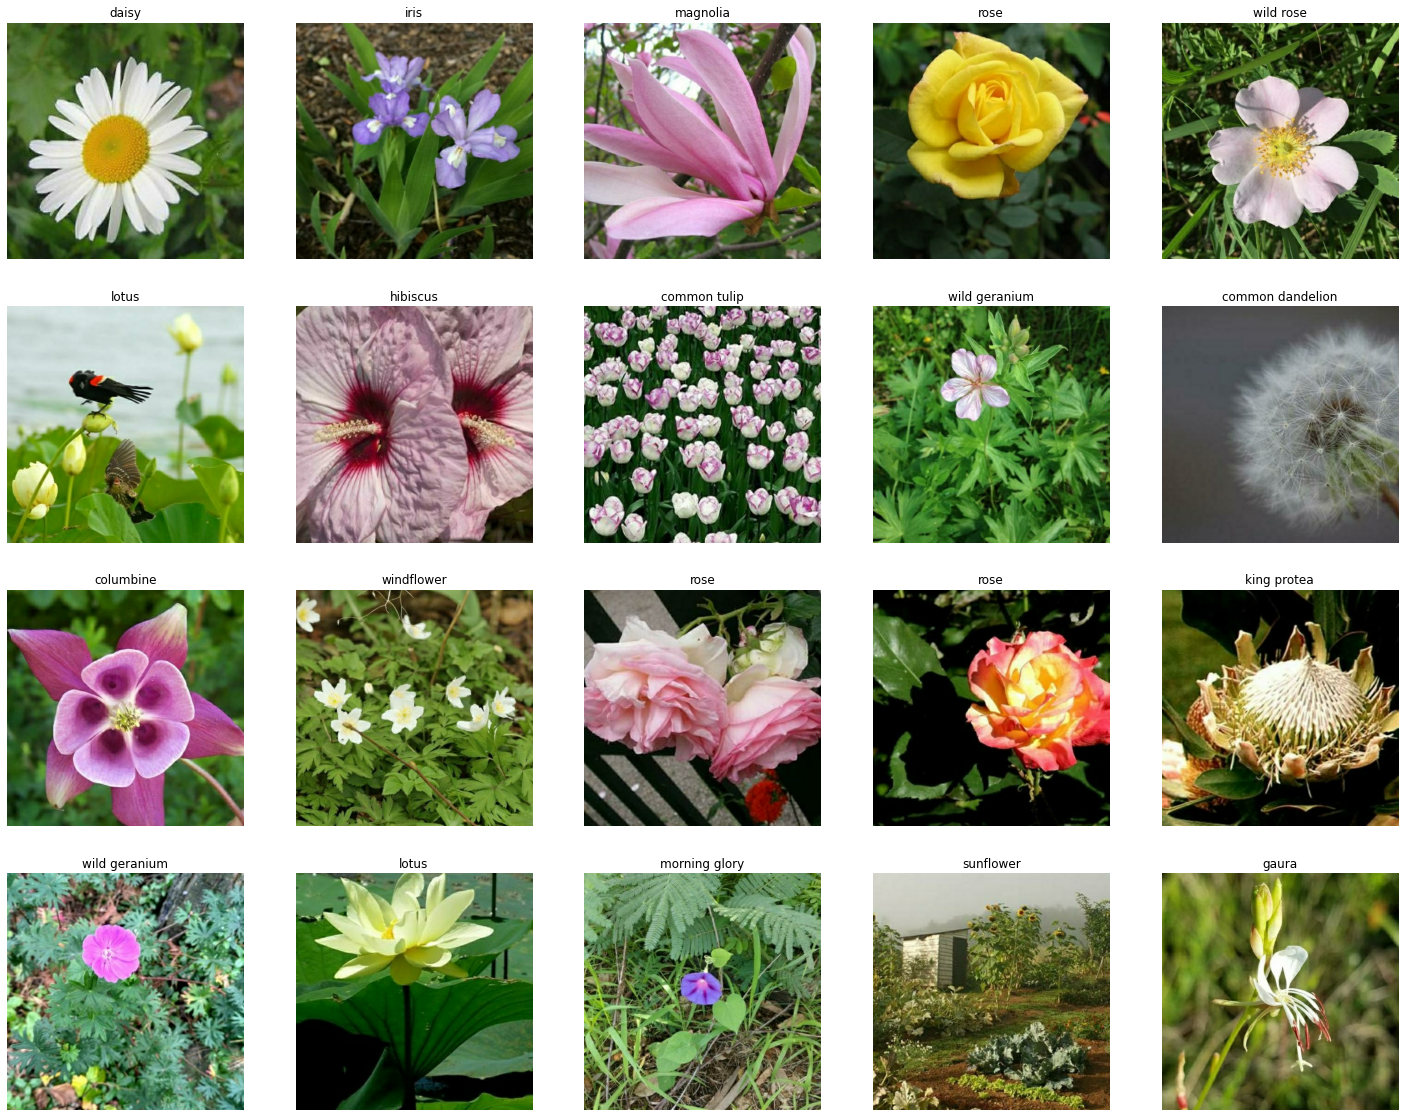

In [7]:
training_dataset = get_training_dataset()
training_dataset = training_dataset.unbatch().batch(20) #20 images, 20 labels in every batch 
train_batch = iter(training_dataset)

for image, label in train_batch:
    print(image.numpy().shape, label.numpy().shape)
    print(type(image.numpy()), type(label.numpy()))
    print(label.numpy())
    break
    
image_batch, label_batch = next(train_batch) # accept the first batch
label_batch = label_batch.numpy()

plt.figure(figsize=(25, 20)) #the size of whole figure
for i in range(20):
  ax = plt.subplot(4, 5, i+1) #the whole figure has 4 rows, 5 columns figures, this is i+1 figure
  #plt.imshow(image_batch[i].numpy().astype("uint8"))  #when image Tensor is the type of Uint8
  plt.imshow(image_batch[i].numpy())
  index = label_batch[i]  #5 classes in[0,4]
  plt.title(CLASS[index])
  plt.axis("off")

(20, 512, 512, 3) (20,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
[ 76  67  95  96  19  31  23  58  10  36  31  50  76  31  62  65 101  14
  22   0]


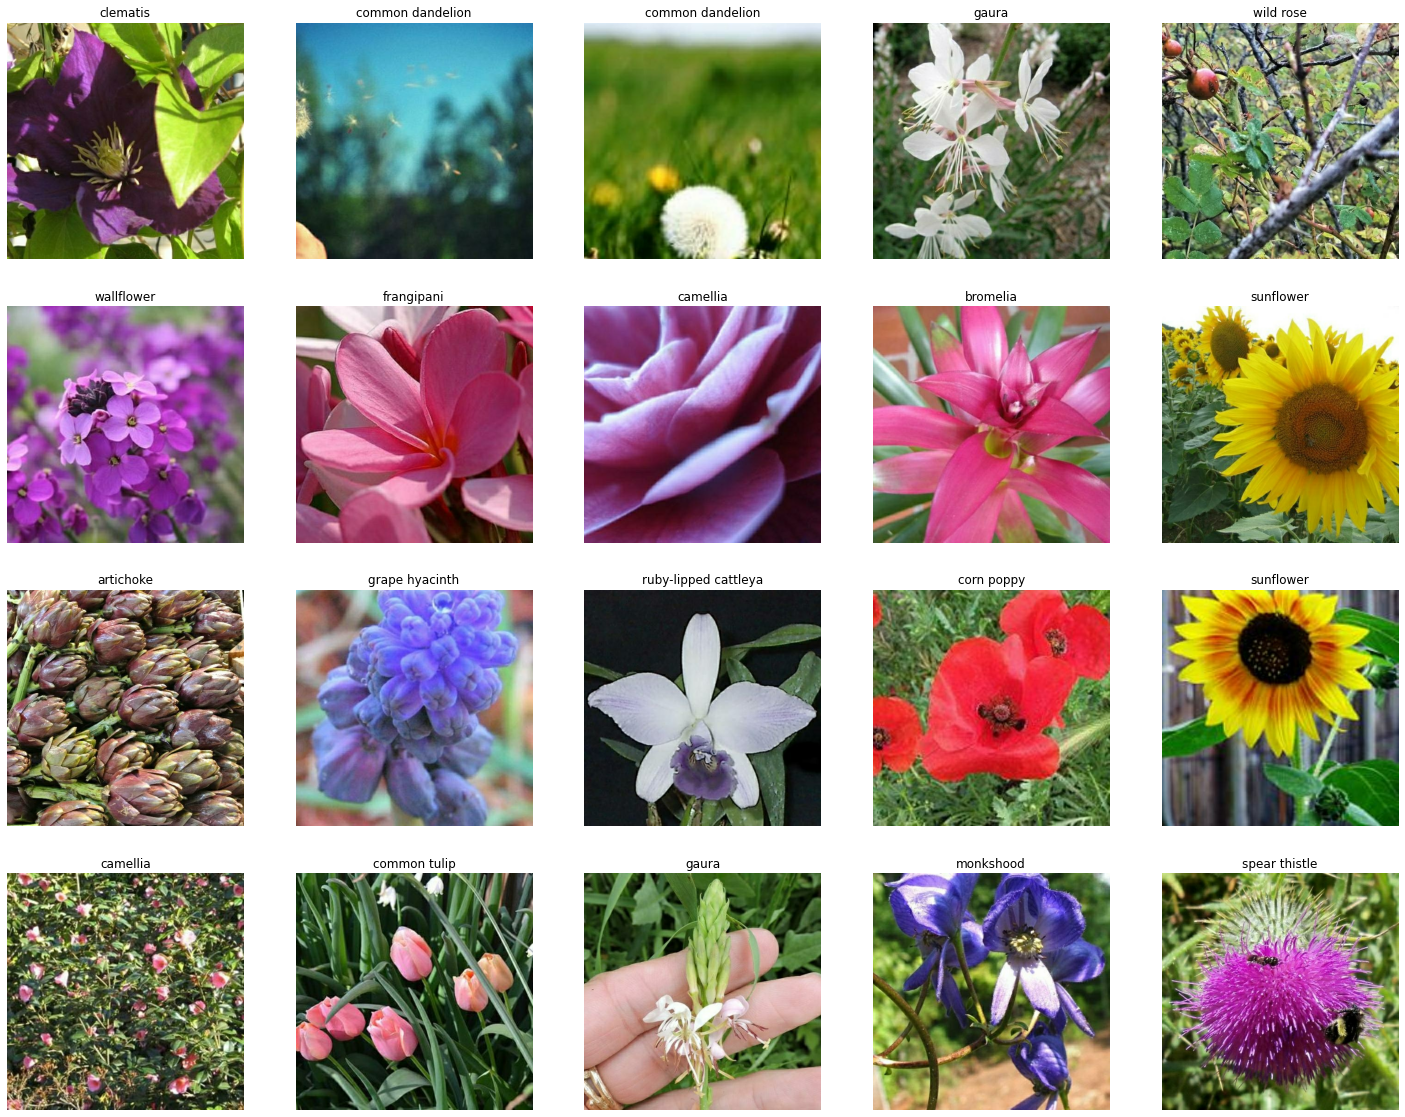

In [8]:
validation_dataset = get_validation_dataset()
validation_dataset = validation_dataset.unbatch().batch(20) #20 images, 20 labels in every batch 
validation_batch = iter(validation_dataset)

for image, label in validation_batch:
    print(image.numpy().shape, label.numpy().shape)
    print(type(image.numpy()), type(label.numpy()))
    print(label.numpy())
    break
    
image_batch, label_batch = next(validation_batch) # accept the first batch
label_batch = label_batch.numpy()

plt.figure(figsize=(25, 20)) #the size of whole figure
for i in range(20):
  ax = plt.subplot(4, 5, i+1) #the whole figure has 4 rows, 5 columns figures, this is i+1 figure
  #plt.imshow(image_batch[i].numpy().astype("uint8"))  #when image Tensor is the type of Uint8
  plt.imshow(image_batch[i].numpy())
  index = label_batch[i]  #5 classes in[0,4]
  plt.title(CLASS[index])
  plt.axis("off")

In [9]:
with strategy.scope():

    pretrained_model = tf.keras.applications.Xception(weights=None, include_top=False)
        
    model = tf.keras.Sequential([
        # convert image format from int [0,255] to the format expected by this model
        tf.keras.layers.Lambda(lambda data: tf.keras.applications.xception.preprocess_input(tf.cast(data, tf.float32)), input_shape=[*IMG_SIZE, 3]),
        pretrained_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(len(CLASS), activation='softmax', name='flower_prob')
    ])
    
model.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy'],
    steps_per_execution=1
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 512, 512, 3)       0         
                                                                 
 xception (Functional)       (None, None, None, 2048)  20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flower_prob (Dense)         (None, 104)               213096    
                                                                 
Total params: 21,074,576
Trainable params: 21,020,048
Non-trainable params: 54,528
_________________________________________________________________


In [10]:
 pretrained_model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 block1_conv1 (Conv2D)          (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, None, None,   128        ['block1_conv1[0][0]']           
 ation)                         32)                                                        

                                                                                                  
 block4_sepconv1 (SeparableConv  (None, None, None,   188672     ['block4_sepconv1_act[0][0]']    
 2D)                            728)                                                              
                                                                                                  
 block4_sepconv1_bn (BatchNorma  (None, None, None,   2912       ['block4_sepconv1[0][0]']        
 lization)                      728)                                                              
                                                                                                  
 block4_sepconv2_act (Activatio  (None, None, None,   0          ['block4_sepconv1_bn[0][0]']     
 n)                             728)                                                              
                                                                                                  
 block4_se

 lization)                      728)                                                              
                                                                                                  
 add_4 (Add)                    (None, None, None,   0           ['block6_sepconv3_bn[0][0]',     
                                728)                              'add_3[0][0]']                  
                                                                                                  
 block7_sepconv1_act (Activatio  (None, None, None,   0          ['add_4[0][0]']                  
 n)                             728)                                                              
                                                                                                  
 block7_sepconv1 (SeparableConv  (None, None, None,   536536     ['block7_sepconv1_act[0][0]']    
 2D)                            728)                                                              
          

 block9_sepconv3_act (Activatio  (None, None, None,   0          ['block9_sepconv2_bn[0][0]']     
 n)                             728)                                                              
                                                                                                  
 block9_sepconv3 (SeparableConv  (None, None, None,   536536     ['block9_sepconv3_act[0][0]']    
 2D)                            728)                                                              
                                                                                                  
 block9_sepconv3_bn (BatchNorma  (None, None, None,   2912       ['block9_sepconv3[0][0]']        
 lization)                      728)                                                              
                                                                                                  
 add_7 (Add)                    (None, None, None,   0           ['block9_sepconv3_bn[0][0]',     
          

                                                                                                  
 block12_sepconv2 (SeparableCon  (None, None, None,   536536     ['block12_sepconv2_act[0][0]']   
 v2D)                           728)                                                              
                                                                                                  
 block12_sepconv2_bn (BatchNorm  (None, None, None,   2912       ['block12_sepconv2[0][0]']       
 alization)                     728)                                                              
                                                                                                  
 block12_sepconv3_act (Activati  (None, None, None,   0          ['block12_sepconv2_bn[0][0]']    
 on)                            728)                                                              
                                                                                                  
 block12_s